In [31]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Optimization
import torch

from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.acquisition import AcquisitionFunction
from botorch.models.gp_regression import HeteroskedasticSingleTaskGP 
from botorch.utils.transforms import normalize, unnormalize


In [32]:
def gp_evaluate(gp, test_x):
    # Get posterior predictions
    gp.eval()
    with torch.no_grad():
        posterior = gp.posterior(test_x)

    mean = posterior.mean.squeeze().numpy()
    lower, upper = posterior.mvn.confidence_region()
    var = posterior.variance.squeeze().numpy()

    return mean, var

# Define all combinations of variables for triple pair plots
variable_combinations = [('time', 'temp'), ('time', 'sulf'), ('time','anly'), ('temp', 'sulf'), ('temp','anly'), ('sulf', 'anly')]
feature_names = ['time', 'temp', 'sulf', 'anly']

# Function to generate input data based on variable combination
def generate_input_data(A, B, c, d, combination):
    if combination == ('time', 'temp'):
        return torch.tensor(np.array([[A[i, j], B[i, j], c, d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('time', 'sulf'):
        return torch.tensor(np.array([[A[i, j], c, B[i, j], d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)        
    elif combination == ('time', 'anly'):
        return torch.tensor(np.array([[A[i, j], d, B[i, j], c ] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('temp', 'sulf'):
        return torch.tensor(np.array([[d, A[i, j], B[i, j], c] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('temp', 'anly'):
        return torch.tensor(np.array([[d, A[i, j], c, B[i, j]] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('sulf', 'anly'):
        return torch.tensor(np.array([[d, c,A[i, j], B[i, j]] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)

def staircase_plot_with_histograms(select, means, var, train_x, train_y, train_yvar, test_x, color, name):
    if select == 'mean':
        versions = means
        cmap_name = color
        y = train_y.numpy()
    elif select == 'var':
        versions = [var] * len(means)  # Use the same variance for all means
        cmap_name = 'seismic'
        y = train_yvar.numpy()

    num_features = train_x.shape[1]  # Assuming 4D input
    feature_names = ["time", "temp", "sulf", "anly"]
    
    fig, axes = plt.subplots(num_features, num_features, figsize=(12, 10))
    count = 0
    for i in range(num_features):
        for j in range(num_features):
            ax = axes[i, j]
            if i < j:  # Upper triangle (leave empty)
                # ax.scatter(train_x[:, j].numpy(), train_x[:, i].numpy(), c=y, cmap=cmap_name, s=500, alpha=0.7,marker='.')
                # ax.set_xlabel(feature_names[j])
                # ax.set_ylabel(feature_names[i])
                # ax.set_box_aspect(1)
                ax.axis('off')
            elif i == j:  # Diagonal (histograms)
                ax.hist(train_x[:, i].numpy(), bins=10, color='gray', edgecolor='black', alpha=0.7)
                ax.set_xlabel(feature_names[i])
                ax.set_box_aspect(1)  # Set the aspect ratio to be equal (cube-shaped)
                ax.set_ylabel("Frequency")
            else:  # Lower triangle (pairwise scatter plots)
                for version in versions:
                    ax.scatter(train_x[:, j].numpy(), train_x[:, i].numpy(), c=y, cmap=cmap_name, s=50, alpha=0.5,marker='o')
                    sc = ax.contourf(A, B, means[count].reshape(num_points, num_points), cmap=cmap_name, alpha=0.7, levels=10,vmax=1, vmin=0)
                fig.colorbar(sc, ax=ax, orientation='vertical')
                ax.set_xlabel(feature_names[j])
                ax.set_ylabel(feature_names[i])
                ax.set_box_aspect(1)
                count += 1
            plt.tight_layout()


>## Import data from Round 1

In [33]:
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

# import data from csv
data_R1 = pd.read_csv('/Users/ctuwsunlab/Documents/GitHub/PNNL-ML_for_Organic_Flow_Battery_Materials/Round1/extracted_data_round1.csv')

# average and standard deviation of the repeats
avg_data01 = data_R1.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['01_time','01_temp','01_sulf','01_anly','01_yield product']].rename(columns = {'01_time':"time",'01_temp':"temp",'01_sulf':"sulf",'01_anly':"anly",'01_yield product':"yield product"})
std_data01 = data_R1.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['01_yield product']].rename(columns = {'01_yield product':"var yield"})
data01 = pd.concat([avg_data01, std_data01], axis=1)


>## Build Gaussian Process Regression

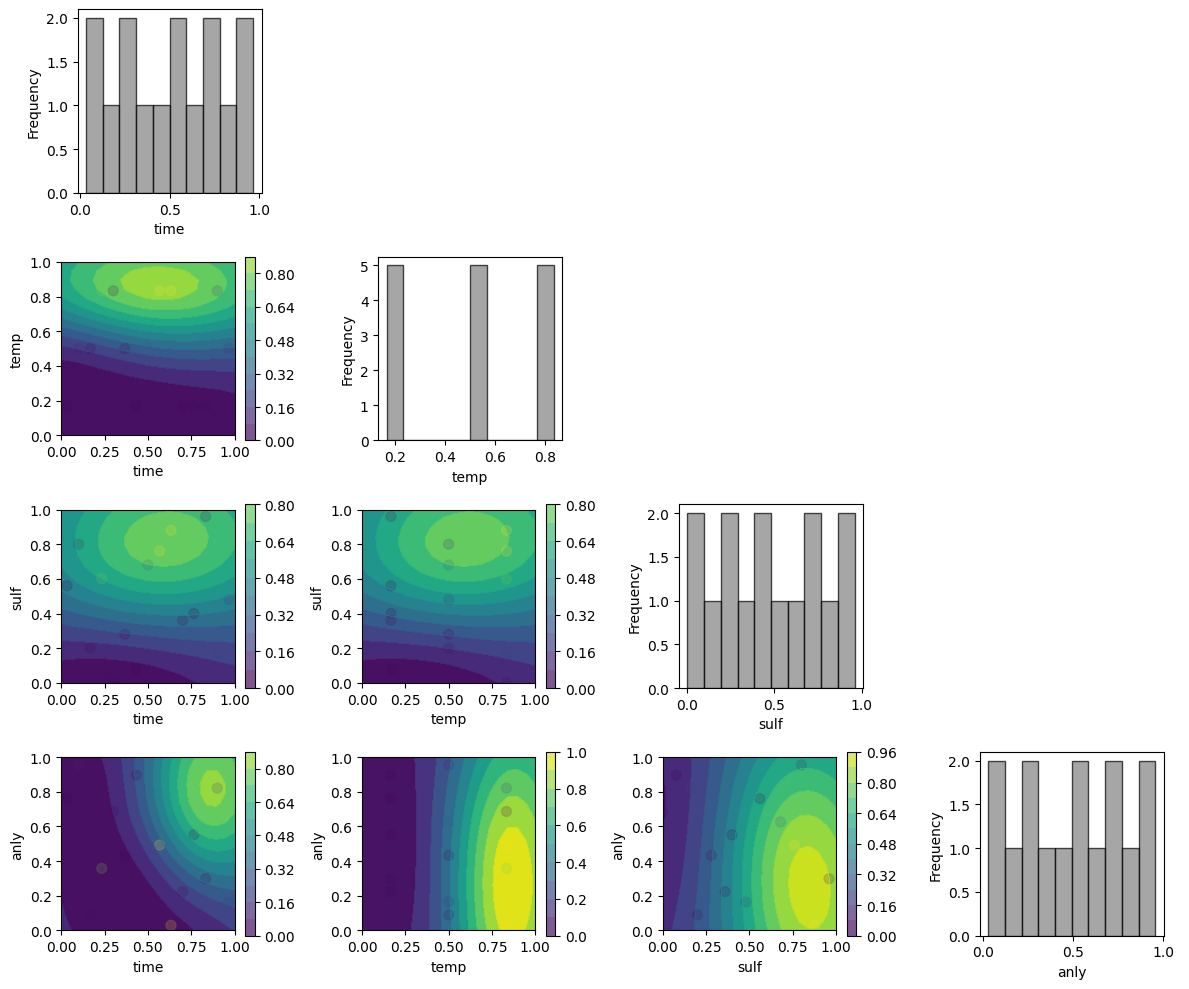

In [34]:
bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)

x = torch.tensor([data01['time'],data01['temp'],data01['sulf'],data01['anly']],dtype=torch.float32).T#
norm_x = normalize(x, bounds)
y = torch.tensor(data01['yield product'],dtype=torch.float32).reshape(-1,1)
yvar = torch.tensor(data01['var yield'],dtype=torch.float32).reshape(-1,1)

train_x = torch.tensor(norm_x, dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y, dtype=dtype)
train_yvar = torch.tensor(yvar, dtype=dtype)

## Create the surrogate model
gp_model = HeteroskedasticSingleTaskGP(train_x, train_y, train_yvar, outcome_transform=None, input_transform=None) 
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

# Visualized the Model
# Generate a grid
num_points = 20  # Points per axis for plotting
a = np.linspace(0, 1, num_points)
b = np.linspace(0, 1, num_points)
c_slices = np.linspace(0, 1, 12)  # Slicing variable
c_fixed = 0.75  # Example fixed value for c - three temperatures
d_fixed =  0.75 # Example fixed value for d - three temperatures

# # Create meshgrid for a, b
A, B = np.meshgrid(a, b)

mean_values = []
var_values = []
for combination in variable_combinations:
    input_data = generate_input_data(A, B, c_fixed, d_fixed, combination)
    mean, var =  gp_evaluate(gp_model, input_data)
    mean_values.append(mean)
    var_values.append(var)

staircase_plot_with_histograms('mean', mean_values, var_values, train_x, train_y, train_yvar , input_data, 'viridis', f"Combination: {combination}")


>## Optimizaiton step

In [35]:
# BO set up
batch_size = 15 #train_size
# For EI 
best_f = torch.tensor(1 ,dtype=dtype) 
# Define the qEI acquisition function
qEI = qExpectedImprovement(model=gp_model, best_f=best_f)

candidate, _ = optimize_acqf(
    acq_function=qEI,
    bounds=torch.tensor([[0., 0., 0. , 0.], [1., 1., 1.,1.]], dtype=dtype, device=device),
    q=batch_size,
    num_restarts=15,
    raw_samples=100,
    options={"dtype": dtype, "device": device}
)

candidates = unnormalize(candidate, bounds)
data = {
    'time': candidates[:,0]//1,
    'temp': candidates[:,1]//1,
    'sulf': candidates[:,2]//1,
    'anly': candidates[:,3]//1
}
data_df = pd.DataFrame(data)


>## Cluster

Centroids of Temperature Clusters:
[[156.  67. 133.]]


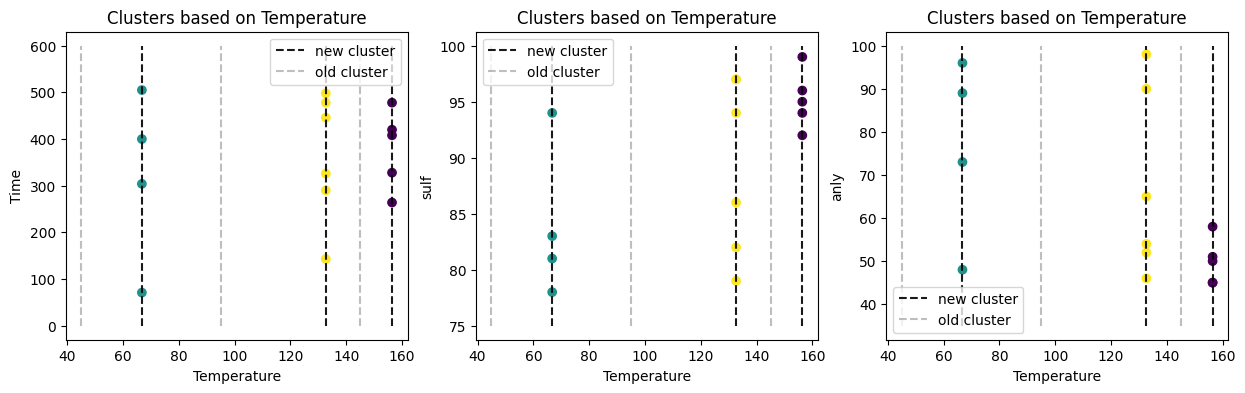

,time,temp,sulf,anly,temp_cluster
0,71.0,67.0,81.0,48.0,1
1,446.0,133.0,97.0,54.0,2
2,326.0,133.0,94.0,46.0,2
3,420.0,156.0,92.0,45.0,0
4,304.0,67.0,94.0,73.0,1
5,143.0,133.0,82.0,65.0,2
6,478.0,156.0,95.0,51.0,0
7,264.0,156.0,96.0,50.0,0
8,505.0,67.0,83.0,89.0,1
9,400.0,67.0,78.0,96.0,1


In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the 'temp' column for clustering
temp_data = data_df[['temp']]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
temp_data_scaled = scaler.fit_transform(temp_data)

# Choose the number of clusters
num_clusters = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=int((20.0+170.0)/2))

data_df['temp_cluster'] = kmeans.fit_predict(temp_data_scaled)
kmeans.fit(temp_data)

# Get the centroids
centroids = kmeans.cluster_centers_
centroids.round()

# Old centroids
old = [45.,145.,95.]

# Display the centroids
print("Centroids of Temperature Clusters:")
print(centroids.round().T)

# Replace the temperature values in lhs_data with the centroid temperatures for the designated clusters
for cluster in range(num_clusters):
    data_df.loc[data_df['temp_cluster'] == cluster, 'temp'] = centroids[cluster][0]

# Visualize the clusters
fig = plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.scatter(data_df['temp'], data_df['time'], c=data_df['temp_cluster'], cmap='viridis')
plt.vlines(centroids,0,600, color = 'k',linestyle='dashed',alpha=0.9,label='new cluster')
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5,label='old cluster')
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.title('Clusters based on Temperature')
plt.legend()

plt.subplot(1,3,2)
plt.scatter(data_df['temp'], data_df['sulf'], c=data_df['temp_cluster'], cmap='viridis')
plt.vlines(centroids,75,100, color = 'k',linestyle='dashed',alpha=0.9,label='new cluster')
plt.vlines(old,75,100, color = 'tab:grey',linestyle='dashed',alpha=0.5,label='old cluster')
plt.xlabel('Temperature')
plt.ylabel('sulf')
plt.title('Clusters based on Temperature')
plt.legend()

plt.subplot(1,3,3)
plt.scatter(data_df['temp'], data_df['anly'], c=data_df['temp_cluster'], cmap='viridis')
plt.vlines(centroids,35,100, color = 'k',linestyle='dashed',alpha=0.9,label='new cluster')
plt.vlines(old,35,100, color = 'tab:grey',linestyle='dashed',alpha=0.5,label='old cluster')
plt.xlabel('Temperature')
plt.ylabel('anly')
plt.title('Clusters based on Temperature')
plt.legend()
plt.show()


# Display the updated lhs_data
data_df.round()

>## Send to data collection